In [1]:
# Import python libraries 
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt 

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

from dataclasses import dataclass 

# User-defined modules
from financial_data import *
from misc import *

In [2]:
df = load_combined()
df.head()

,loan_date,loan_amount,duration,payments,status,frequency,account_date,clients,num_cards,card_issued,...,no_of_municipalities_with_inhabitants_between_1000_to_9999,no_of_municipalities_with_inhabitants_greater_than_10000,no_of_cities,ratio_of_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_of_enterpreneurs_per_1000_inhabitants,no_of_commited_crimes_95,no_of_commited_crimes_96
0,1994-01-05,0.129680,0.25,0.319488,A,monthly,1993-02-26,2,0,1900-01-01,...,0.00,0.2,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,1996-04-29,0.043179,0.00,0.231001,B,monthly,1995-04-07,1,0,1900-01-01,...,0.35,0.2,0.6,0.500756,0.224329,0.183099,0.182832,0.488372,0.017452,0.014926
2,1997-12-08,0.043179,0.00,0.231001,A,monthly,1996-07-28,1,0,1900-01-01,...,0.90,0.4,0.5,0.352496,0.402392,0.535211,0.478261,0.174419,0.056623,0.050896
3,1998-10-14,0.535129,1.00,0.520924,D,monthly,1997-08-18,1,0,1900-01-01,...,0.15,0.2,0.3,0.370651,0.098623,0.338028,0.357860,0.453488,0.008779,0.006659
4,1998-04-19,0.180520,0.75,0.208516,C,weekly,1997-08-08,1,0,1900-01-01,...,0.15,0.2,0.3,0.284418,0.065899,0.408451,0.395764,0.453488,0.002133,0.002148


In [3]:
def transform(df):
    df['frequency'] = df['frequency'].astype('category').cat.codes
    df['status']    = df['status'].astype('category').cat.codes
    df['district_name'] = df['district_name'].astype('category').cat.codes
    df['owner_gender'] = df['owner_gender'].astype('category').cat.codes
    df['region'] = df['region'].astype('category').cat.codes
    X = df.drop(columns=[ 'status', 'loan_date', 'card_issued', 'owner_birth', 'account_date'])
    y = df['status']
    return X, y

In [4]:
X, y = transform(df)

# Dimensionality reduction using PCA 
from sklearn.decomposition import PCA
reducedX = PCA(n_components='mle', svd_solver='full').fit_transform(X)

#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(reducedX, y, test_size=0.33, random_state=42)

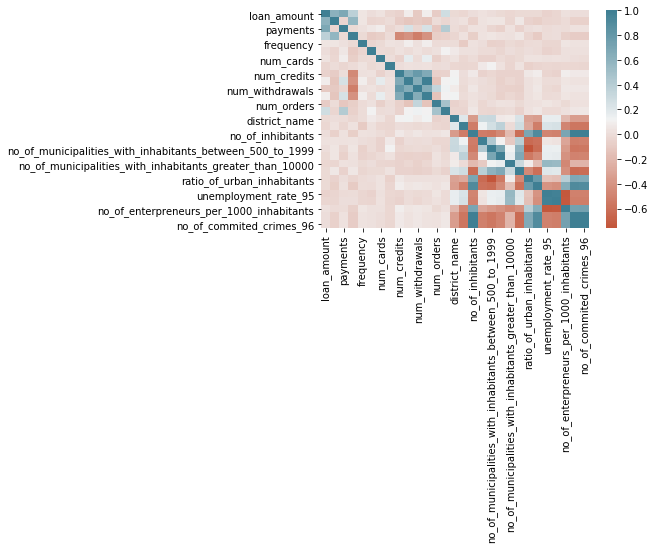

In [5]:
corr = df.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(20,220,n=200))

### K-Nearest Neighbor (kNN)


In [6]:
# Using GridSearchCV to find optimal parameter k
param = {'n_neighbors': np.arange(1,100)}
neigh = KNeighborsClassifier()
clf = GridSearchCV(neigh,param,scoring='accuracy',refit=True,cv=5)
clf.fit(X_train,y_train)
clf.best_params_

{'n_neighbors': 73}

In [7]:
def kNN(k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    return accuracy, mse

Text(0.5,1,'Mean squared error vs k')

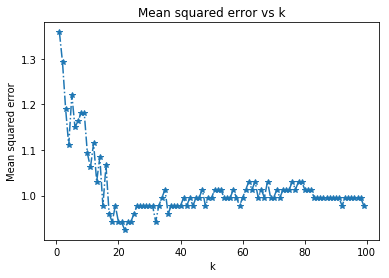

In [8]:
# Using elbow method to determine optimal k 
k = np.arange(1,100)
accuracy = []
MSE = []
for i in k:
    acc, mse = kNN(i)
    accuracy.append(acc)
    MSE.append(mse)
    
# plt.plot(k, accuracy, '-.*')
# plt.xlabel("k")
# plt.ylabel("Accuracy score (%)")
# plt.title("Accuracy score vs k")
plt.plot(k, MSE, '-.*')
plt.xlabel("k")
plt.ylabel("Mean squared error")
plt.title("Mean squared error vs k")

Using the elbow method, the optimal k is chose to be 70.

Text(0.5,1,'5 Fold CV: KNN with k=73\n Accuracy=70.53 $\\pm$ 1.99')

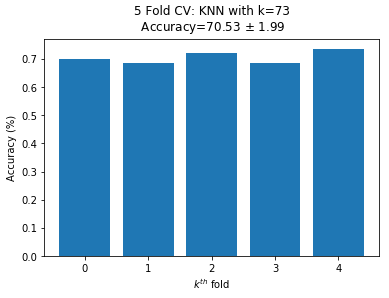

In [9]:
# Cross validation
k = clf.best_params_['n_neighbors']
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

skf_acc=[]
skf_MSE=[]
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    acc, mse = kNN(k)
    skf_acc.append(acc)
    skf_MSE.append(mse)
    
std_acc, ave_acc = np.std(skf_acc), np.mean(skf_acc)
plt.bar(np.arange(num_folds), skf_acc)
plt.xlabel("$k^{th}$ fold")
plt.ylabel("Accuracy (%)")
plt.title("%d Fold CV: KNN with k=%d\n Accuracy=%.2f $\pm$ %.2f" % (num_folds,k,ave_acc*100,std_acc*100))


### Support Vector Machine

In [10]:
# params = {'kernel': ('linear', 'rbf'), 'C':[1,10]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, params, scoring='accuracy', cv=num_folds)
# clf.fit(X_train,y_train)
# clf.best_params_